### Read in data

In [1]:
import psycopg2
import pandas as pd
import numpy as np
import time
from datetime import timedelta, datetime
from matplotlib import pyplot as plt
from collections import defaultdict
import random

In [2]:
con = psycopg2.connect(user = "postgres",
                       password = "",
                       host = "127.0.0.1",
                       port = "5432",
                       database = "adj_noun_pairs")

try:
    cursor = con.cursor();
except (Exception, psycopg2.Error) as error:
    print("Error in Connection",error)

In [3]:
cursor.execute("SELECT * FROM final_pairs WHERE noun IN (SELECT noun FROM final_pairs GROUP BY noun HAVING COUNT(*) > 2)")
all_pairs = cursor.fetchall() 

In [4]:
len(all_pairs)

115295

In [5]:
all_pairs[0]

('eelmine', 'aasta', 53250)

In [5]:
# nouns = list(set([pair[1] for pair in all_pairs]))
# adjectives = list(set([pair[0] for pair in all_pairs]))

In [6]:
dup_nouns = [pair[1] for pair in all_pairs]
# Easy naive for-loop to keep order so results wouldn't change each time
nouns = []
for noun in dup_nouns:
    if noun not in nouns:
        nouns.append(noun)

In [7]:
dup_adjectives = [pair[0] for pair in all_pairs]
adjectives = []
for adj in dup_adjectives:
    if adj not in adjectives:
        adjectives.append(adj)

In [8]:
data = pd.DataFrame(0, index=nouns, columns=adjectives)
data.head()

,eelmine,järgmine,viimane,käesolev,kogu,kohalik,suur,pikk,juriidiline,tulev,...,realiseeritav,valgustatav,vajuv,väikesekasvuline,väikeseformaadiline,õlirikas,õigusetu,oletuslik,raugematu,raudteeäärne
aasta,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aeg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
määrus,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
omavalitsus,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
osa,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
for tup in all_pairs:
    data.loc[tup[1], tup[0]] = tup[2]

In [10]:
# data = data.fillna(0)
data.head()

,eelmine,järgmine,viimane,käesolev,kogu,kohalik,suur,pikk,juriidiline,tulev,...,realiseeritav,valgustatav,vajuv,väikesekasvuline,väikeseformaadiline,õlirikas,õigusetu,oletuslik,raugematu,raudteeäärne
aasta,53250,38107,24410,11753,1115,40,114,1562,0,12634,...,0,0,0,0,0,0,0,0,0,0
aeg,75,65,27915,1227,24997,1373,194,14913,0,18,...,0,0,0,0,0,0,0,0,0,0
määrus,16,110,17,27514,30,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
omavalitsus,30,67,44,0,31,24261,84,0,12,0,...,0,0,0,0,0,0,0,0,0,0
osa,201,436,918,118,51,10,22165,25,0,17,...,0,0,0,0,0,0,0,0,0,0


In [11]:
data.shape

(5817, 7358)

The following two are examples found for some of the nouns that were removed

In [359]:
cursor.execute("SELECT * FROM final_pairs WHERE noun = 'võrdõiguslikkus'")
cursor.fetchall()

[('sooline', 'võrdõiguslikkus', 615)]

In [398]:
cursor.execute("SELECT * FROM final_pairs WHERE noun = 'kesktee'")
cursor.fetchall()

[('kuldne', 'kesktee', 181)]

### LDA

In [12]:
from sklearn.decomposition import LatentDirichletAllocation

In [13]:
lda = LatentDirichletAllocation(n_components=1000, random_state=0)

In [14]:
start = datetime.now()
print(str(timedelta(seconds=time.time()+10800)).split(", ")[1])
results = lda.fit_transform(data)
print(str(timedelta(seconds=time.time()+10800)).split(", ")[1])
print(datetime.now()-start)

2:39:52.110893
2:46:15.396901
0:06:23.287005


In [15]:
topics = {}
for i in range(1000):
    topics[i] = []

for idx, prob in enumerate(results):
    topics[np.argmax(prob)].append(data.index[idx])

In [168]:
import pickle

with open("lda_topics.pickle", "wb") as f:
    pickle.dump(topics, f)

In [158]:
# np.save("lda_1000_nouns_topics.npy", results)

In [161]:
# with open("lda_1000_model.pickle", "wb") as f:
#     pickle.dump(lda, f)

### Results

In [16]:
adjs_in_topics = pd.DataFrame(lda.components_, columns=data.columns)

In [17]:
adjs_in_topics.head()

,eelmine,järgmine,viimane,käesolev,kogu,kohalik,suur,pikk,juriidiline,tulev,...,realiseeritav,valgustatav,vajuv,väikesekasvuline,väikeseformaadiline,õlirikas,õigusetu,oletuslik,raugematu,raudteeäärne
0,570.741504,445.221428,1404.790056,13.756003,72.793022,21.852019,28.644137,37.534237,0.001,12.782522,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
1,0.001000,0.001000,5.227010,0.001000,8.975630,0.001000,10.675260,0.001000,0.001,0.001000,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
2,0.001000,166.437389,134.072860,0.001000,29.245233,15.127251,155.339158,0.001000,0.001,11.127216,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
3,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001,0.001000,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
4,0.001000,0.001000,41.782700,0.001000,0.001000,0.001000,236.242286,0.001000,0.001,0.001000,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001


#### Cluster from Jaccard
['automaatkast', 'automaatkäigukast', 'käsikast'] was a cluster in Jaccard similarity clustering, this is to see where the words of that cluster are put in NMF results

In [113]:
for i, words in topics.items():
    if 'automaatkast' in words:
        print(i, words)

399 ['proteiin', 'käigukast', 'käsikast', 'automaatkast', 'vrakk']


#### Month topics

In [18]:
kuud = ['jaanuar', 'veebruar', 'märts', 'aprill', 'mai', 'juuni', 'juuli', 'august', 'september', 'oktoober', 'november', 'detsember']
idx = []

for kuu in kuud:
    for topic, words in topics.items():
        if kuu in words:
            idx.append(topic)
            continue

In [19]:
idx

[819, 819, 819, 819, 777, 153, 153, 436, 436, 436, 436]

In [20]:
for i in set(idx):
    print(f"topic {i}, with {idx.count(i)} month(s)")
    print(topics[i])
    print("Most common adjectives in topic:")
    print(adjs_in_topics.loc[i][adjs_in_topics.loc[i] > 10].sort_values(ascending=False).head())
    print("----------------------------")

topic 777, with 1 month(s)
['ilm', 'juuni']
Most common adjectives in topic:
ilus       1737.539040
soe        1463.630247
külm       1426.606272
halb       1087.312467
vihmane     784.376655
Name: 777, dtype: float64
----------------------------
topic 153, with 2 month(s)
['suvepäev', 'pirukas', 'pann', 'pliit', 'võileib', 'august', 'juuli', 'armulugu']
Most common adjectives in topic:
kuum      2570.954491
valmis     922.386875
Name: 153, dtype: float64
----------------------------
topic 819, with 4 month(s)
['eelarve', 'riigieelarve', 'eurolaul', 'kasumiprognoos', 'MM-sari', 'MK-sari', 'laureaat', 'lõpetaja', 'eurovisioon', 'riigieksam', 'lauluvõistlus', 'õllesummer', 'abiturient', 'jaanuar', 'aprill', 'suvelavastus', 'märts', 'komeet', 'põhiturniir', 'võidupüha', 'veebruar']
Most common adjectives in topic:
tänavune     9271.572132
uus           274.671727
järgmine       49.422115
olnud          41.592644
katseline      21.848503
Name: 819, dtype: float64
--------------------------

#### Days topics

In [21]:
days = ['esmaspäev', 'teisipäev', 'kolmapäev', 'neljapäev', 'reede', 'laupäev', 'pühapäev']
idx2 = []

for day in days:
    for topic, words in topics.items():
        if day in words:
            idx2.append(topic)
            continue

In [22]:
idx2

[325, 436, 436, 765, 436, 436, 436]

In [23]:
for i in set(idx2):
    print(i, ":", topics[i])
    print("Most common adjectives in topic:")
    print(adjs_in_topics.loc[i][adjs_in_topics.loc[i] > 10].sort_values(ascending=False).head())
    print("----------------------------")

765 : ['nädal', 'õhtu', 'neljapäev', 'koosseis', 'lõik', 'lugemine', 'majandusaasta', 'eelarveaasta', 'olümpia', 'kalendriaasta', 'postitus', 'post', 'aastavahetus', 'loendus', 'kütteperiood', 'maksustamisperiood', 'kalandusaasta', 'aruandeaasta']
Most common adjectives in topic:
eelmine     37353.330967
järgmine    10610.394181
viimane      6736.124606
terve         538.645775
kogu          483.201015
Name: 765, dtype: float64
----------------------------
436 : ['reede', 'sügis', 'nädalavahetus', 'kolmapäev', 'teisipäev', 'laupäev', 'pühapäev', 'nädalalõpp', 'detsember', 'oktoober', 'september', 'november']
Most common adjectives in topic:
läinud      10494.540820
eelmine      3825.620999
eelolev      2689.682555
tulev        1309.282532
järgmine      499.123069
Name: 436, dtype: float64
----------------------------
325 : ['aasta', 'hooaeg', 'sajand', 'esmaspäev']
Most common adjectives in topic:
eelmine     57798.473849
järgmine    40808.817224
viimane     16531.973503
tulev       15

#### Artistic professions

In [24]:
jobs = ['laulja', 'näitleja', 'kunstnik', 'tantsija', 'artist']
idx3 = []

for job in jobs:
    for topic, words in topics.items():
        if job in words:
            idx3.append(topic)
            continue

In [25]:
idx3

[435, 435, 435, 435, 435]

In [26]:
for i in set(idx3):
    print(i, ":", topics[i])
    print("Most common adjectives in topic:")
    print(adjs_in_topics.loc[i][adjs_in_topics.loc[i] > 10].sort_values(ascending=False).head())
    print("----------------------------")

435 : ['näitleja', 'kunstnik', 'laulja', 'muusik', 'autor', 'teadlane', 'kirjanik', 'lavastaja', 'talent', 'helilooja', 'disainer', 'arhitekt', 'tantsija', 'soomlane', 'pianist', 'lauljatar', 'dirigent', 'moekunstnik', 'mängumees', 'luuletaja', 'kotkas', 'näitlejanna', 'jalgpallur', 'vaataja', 'režissöör', 'suusataja', 'artist', 'peategelane', 'armastaja', 'solist', 'jalgrattur', 'korvpallur', 'täiskasvanu', 'rezhissöör', 'inglane', 'sakslane', 'tenor', 'tartlane', 'rattur', 'interpreet', 'kriitik', 'võidusõitja', 'kergejõustiklane', 'viiuldaja', 'haritlane', 'algaja', 'poeet', 'tööhõive', 'perenaine', 'britt', 'looja', 'fotograaf', 'intellektuaal', 'mänd', 'talupidaja', 'näitlejatar', 'isane', 'ajaloolane', 'ajateenija', 'lätlane', 'prantslane', 'lauljanna', 'lõvi', 'hispaanlane', 'sopran', 'põder', 'leedulane', 'äss', 'ameeriklanna', 'judokas', 'tohter', 'reformierakondlane', 'austraallane', 'insener', 'brasiillane', 'jaapanlane', 'vehkleja', 'infokeskus', 'lendur', 'autovaras', 'emm

In [170]:
len(topics[435])

83

In [173]:
ametid = ['näitleja', 'kunstnik', 'laulja', 'muusik', 'autor', 'teadlane', 'kirjanik', 'lavastaja', 'helilooja', 'disainer', 'arhitekt', 'tantsija', 'pianist', 'lauljatar', 'dirigent', 'moekunstnik', 'luuletaja', 'näitlejanna', 'jalgpallur', 'režissöör', 'suusataja', 'artist', 'solist', 'jalgrattur', 'korvpallur', 'režissöör', 'rattur', 'interpreet', 'kriitik', 'võidusõitja', 'kergejõustiklane', 'viiuldaja', 'haritlane', 'poeet', 'fotograaf', 'talupidaja', 'näitlejatar', 'ajaloolane', 'ajateenija', 'lauljanna', 'judokas', 'tohter', 'reformierakondlane', 'insener', 'vehkleja', 'lendur', 'kitarrist', 'balletitantsija']
rahvused = ['soomlane', 'inglane', 'sakslane', 'tartlane', 'britt', 'lätlane', 'prantslane', 'hispaanlane', 'leedulane', 'ameeriklanna', 'austraallane', 'brasiillane', 'jaapanlane']
muu_inimene = ['talent', 'mängumees', 'vaataja', 'peategelane', 'armastaja', 'täiskasvanu', 'tenor', 'algaja', 'perenaine', 'looja', 'intellektuaal', 'sopran', 'äss', 'autovaras', 'emme']
loodus = ['kotkas', 'mänd', 'isane', 'lõvi', 'põder']
muu = ['tööhõive', 'infokeskus']

In [174]:
len(ametid) + len(rahvused) + len(muu_inimene) + len(loodus) + len(muu)

83

In [192]:
per_group = [len(ametid), len(rahvused), len(muu_inimene), len(loodus), len(muu)]
lbls = ["ametid", "rahvused", "muu, inimene", "loomad", "muu"]

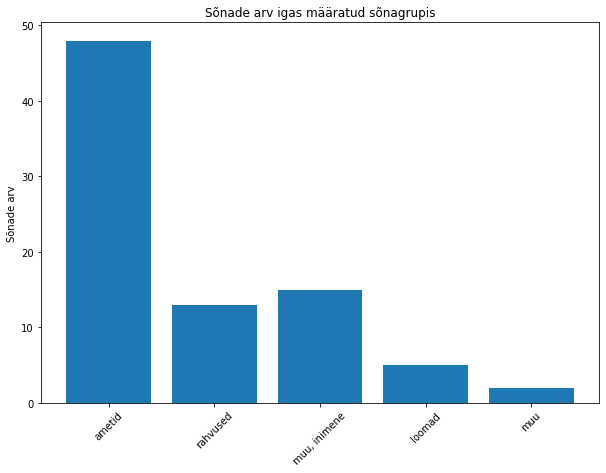

In [193]:
plt.figure(figsize=(10, 7))
plt.bar(lbls, per_group)
plt.xticks(rotation = 45)
plt.ylabel("Sõnade arv")
plt.title("Sõnade arv igas määratud sõnagrupis")
plt.savefig("word_count_lda_topic.png")
plt.show()

#### Sports

In [27]:
spordialad = ['jalgpall', 'korvpall', 'pesapall', 'võrkpall', 'golf', 'tennis']
idx4 = []

for spordiala in spordialad:
    for topic, words in topics.items():
        if spordiala in words:
            idx4.append(topic)
            continue

In [28]:
idx4

[200, 412, 412]

In [194]:
for i in set(idx4):
    print(i, ":", topics[i])
    print(adjs_in_topics.loc[i][adjs_in_topics.loc[i] > 10].sort_values(ascending=False).head())
    print("----------------------------")

200 : ['jalgpall', 'keskmängija', 'ääremängija', 'poolkaitsja', 'tsenter', 'võistlusmaa', 'tagamängija', 'võidusõit', 'eraldistart', 'kaitsja', 'tagamees', 'rannariba', 'suusarada', 'publikukatse']
pikkune          4052.477314
ründav            265.001000
vasakukäeline      52.001000
uus                10.563259
Name: 200, dtype: float64
----------------------------
412 : ['osa', 'tänu', 'hulk', 'tõenäosus', 'saal', 'vahe', 'määr', 'slämm', 'ekraan', 'lootus', 'koormus', 'rõõm', 'risk', 'pauk', 'lava', 'segadus', 'armastus', 'au', 'puudus', 'tükk', 'nõudlus', 'teater', 'vanker', 'eelis', 'pluss', 'pettumus', 'populaarsus', 'osakaal', 'panus', 'kivi', 'eeskuju', 'pingutus', 'hüpe', 'tööpuudus', 'potentsiaal', 'töökoormus', 'pidu', 'mägi', 'staar', 'kära', 'menu', 'rahvahulk', 'skandaal', 'veoauto', 'kott', 'kaal', 'naaber', 'kaubanduskeskus', 'protsent', 'sport', 'kaar', 'kergendus', 'peo', 'kaubamaja', 'tugi', 'tulekahju', 'edusamm', 'tung', 'varvas', 'tüli', 'väin', 'hunnik', 'miinus'

### Adjectives in topics

#### Finding properties of nouns

In [243]:
def top_10_nouns_for_adjective(results, adj_index):
    probs= [(index, result) for index, result in enumerate(results[:, adj_index])]
    sorted_probs = sorted(probs, key=lambda x: x[1], reverse=True)
    top_10 = [x[0] for x in sorted_probs[:10]]
    return data.iloc[top_10]

In [221]:
adjs_in_topics['suur'].sort_values(ascending=False).head(10)

412    160773.051897
795      5762.924096
450      4509.747714
465      3057.443684
906      2740.613407
285      2566.488133
121      2288.356731
791      1763.049285
355      1749.769472
605      1432.859406
Name: suur, dtype: float64

In [283]:
adjs_in_topics.loc[412].sort_values(ascending=False).head(10)

suur            160773.051897
mõtteline          952.337892
väike              437.588991
tühine             286.312431
veepealne          213.016354
kaduvväike         158.001000
sõnaline           123.452745
puutetundlik       104.001000
arvutu              94.001000
veealune            91.077582
Name: 412, dtype: float64

In [244]:
top_10_nouns_for_adjective(results, 412)

,eelmine,järgmine,viimane,käesolev,kogu,kohalik,suur,pikk,juriidiline,tulev,...,realiseeritav,valgustatav,vajuv,väikesekasvuline,väikeseformaadiline,õlirikas,õigusetu,oletuslik,raugematu,raudteeäärne
tänu,0,0,0,0,0,0,16634,0,0,0,...,0,0,0,0,0,0,0,0,0,0
slämm,0,0,38,0,0,0,1419,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tõenäosus,0,0,0,0,0,0,4471,0,0,0,...,0,0,0,0,0,0,0,0,0,0
töökoormus,0,0,0,0,0,0,337,0,0,0,...,0,0,0,0,0,0,0,0,0,0
vanker,0,0,0,0,0,0,483,0,0,0,...,0,0,0,0,0,0,0,0,0,0
õhin,0,0,0,0,0,0,87,0,0,0,...,0,0,0,0,0,0,0,0,0,0
saladuskate,0,0,0,0,0,0,116,0,0,0,...,0,0,0,0,0,0,0,0,0,0
allahindlus,0,0,0,0,0,0,100,0,0,0,...,0,0,0,0,0,0,0,0,0,0
osatähtsus,0,0,15,0,0,0,162,0,0,0,...,0,0,0,0,0,0,0,0,0,0
hundikoer,0,0,0,0,0,0,72,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [245]:
adjs_in_topics['uus'].sort_values(ascending=False).head(10)

343    144594.599963
325      7007.374924
240      5013.053514
118      4824.742813
459      4330.708109
632      3192.509450
106      3065.636168
398      2727.361235
565      2632.024542
574      2493.604951
Name: uus, dtype: float64

In [284]:
adjs_in_topics.loc[343].sort_values(ascending=False).head(10)

uus                  144594.599963
suur                     63.686882
olnud                    52.142329
siiratud                 50.001000
pealekasvav              48.001000
sirguv                   36.001000
jõudev                   14.379150
praegune                 14.210404
olev                     12.359257
kolmekümneaastane        12.001000
Name: 343, dtype: float64

In [248]:
top_10_nouns_for_adjective(results, 343)[['uus']]

,uus
neer,148
tulija,660
elurajoon,144
tuumajaam,189
ravikindlustusseadus,117
põhimäärus,118
koalitsioonilepe,110
spordihall,104
alkoholiseadus,94
väikeauto,81


In [252]:
cursor.execute("SELECT * FROM final_pairs WHERE noun = 'ravikindlustusseadus'")
cursor.fetchall() 

[('uus', 'ravikindlustusseadus', 117),
 ('jõustuv', 'ravikindlustusseadus', 13),
 ('kehtiv', 'ravikindlustusseadus', 12)]

In [254]:
adjs_in_topics['endine'].sort_values(ascending=False).head(10)

335    24633.723675
398     7220.963728
638     1386.961763
727      678.035955
785      577.205767
527      483.909160
627      475.670590
490      467.000610
565      408.796024
354      311.136676
Name: endine, dtype: float64

In [285]:
adjs_in_topics.loc[335].sort_values(ascending=False).head(10)

endine      24633.723675
uus          1210.649953
kunagine      257.626057
praegune      131.363435
olnud          59.670518
senine         41.860616
eelmine         0.189086
osanud          0.041025
kohalik         0.024580
tollane         0.003812
Name: 335, dtype: float64

In [255]:
top_10_nouns_for_adjective(results, 335)[['endine']]

,endine
tippsportlane,130
töökaaslane,141
komissar,90
kasvandik,37
alluv,101
raamatupidaja,72
poksija,68
riigisekretär,42
asetäitja,91
vabadusvõitleja,65


In [280]:
adjs_in_topics['kuiv'].sort_values(ascending=False).head(10)

777    607.492401
110    486.877441
860    286.001000
640    262.517732
710    229.915349
642    197.293564
973    154.757928
811    151.001000
38     135.065339
682     54.319686
Name: kuiv, dtype: float64

In [291]:
adjs_in_topics.loc[110].sort_values(ascending=False).head(10)

kuiv                486.877441
administratiivne    238.343556
jõuetu               95.001000
haukuv               55.001000
allasurutud          13.153012
võimetu              13.001000
metsik                2.124186
suur                  0.921857
pime                  0.001028
koolikohustuslik      0.001000
Name: 110, dtype: float64

In [292]:
top_10_nouns_for_adjective(results, 110)[['kuiv']]

,kuiv
suutlikkus,0
köha,50
raev,0
hein,38
siider,13
viha,0
teekate,13
skoor,10
trenn,77
lapp,28


In [302]:
adjs_in_topics.loc[777].sort_values(ascending=False).head(10)

ilus       1737.539040
soe        1463.630247
külm       1426.606272
halb       1087.312467
vihmane     784.376655
kuum        626.311995
kuiv        607.492401
hea         474.287163
jahe        435.084748
palav       432.882732
Name: 777, dtype: float64

In [305]:
print(list(adjs_in_topics.loc[777].sort_values(ascending=False).head(10).index))

['ilus', 'soe', 'külm', 'halb', 'vihmane', 'kuum', 'kuiv', 'hea', 'jahe', 'palav']


In [281]:
top_10_nouns_for_adjective(results, 777)[['kuiv']]

,kuiv
ilm,600
juuni,0
jaanipäev,0
kliima,33
hommik,0
suvi,178
suvepäev,0
rõhutamine,0
balletitantsija,0
kuumalaine,0


In [293]:
topics[777]

['ilm', 'juuni']

In [294]:
probs= [(index, result) for index, result in enumerate(results[:, 777])]
sorted_probs = sorted(probs, key=lambda x: x[1], reverse=True)

In [300]:
sorted_probs[:10]

[(115, 0.9925496569639267),
 (5364, 0.27705892895192974),
 (4181, 0.1094975725244189),
 (1568, 0.025513956453961192),
 (112, 0.018343928424436655),
 (88, 0.0046246699438789),
 (1441, 4.146474256668826e-05),
 (5815, 3.2258064516129156e-05),
 (5814, 3.2258064516129074e-05),
 (5812, 3.225806451612907e-05)]

In [306]:
list(data.iloc[[115, 5364, 4181, 1568, 112, 88, 1441]].index)

['ilm', 'juuni', 'jaanipäev', 'kliima', 'hommik', 'suvi', 'suvepäev']

In [282]:
adjs_in_topics.loc[777].sort_values(ascending=False).head(10)

ilus       1737.539040
soe        1463.630247
külm       1426.606272
halb       1087.312467
vihmane     784.376655
kuum        626.311995
kuiv        607.492401
hea         474.287163
jahe        435.084748
palav       432.882732
Name: 777, dtype: float64

In [287]:
adjs_in_topics['valge'].sort_values(ascending=False).head(10)

805    11903.350954
637     3829.188459
640      906.980428
936      597.272464
294      473.001000
939      455.322021
286      388.831549
490      378.001000
585      315.100034
264      212.369111
Name: valge, dtype: float64

In [288]:
adjs_in_topics.loc[805].sort_values(ascending=False).head(10)

valge           11903.350954
redutseeriv       196.001000
kahtlustatud       65.001000
üleliigne          46.378752
punetav            27.615969
kupardamata        20.001000
suur               18.445862
pruunikas          17.353810
40kraadine         13.456356
ekstra             13.001000
Name: 805, dtype: float64

In [270]:
top_10_nouns_for_adjective(results, 805)[['valge']]

,valge
triiksärk,57
pulber,344
vares,117
põll,43
suhkur,580
sukkpüksid,36
hiinlane,112
hõlst,31
lina,240
peakapsas,36


In [289]:
adjs_in_topics['märg'].sort_values(ascending=False).head(10)

878    560.025717
957    246.958835
43      94.570987
682     89.135767
777     66.292565
284     64.001000
561     41.473305
38      33.906186
837     30.691561
264     27.525228
Name: märg, dtype: float64

In [290]:
adjs_in_topics.loc[878].sort_values(ascending=False).head(10)

märg           560.025717
väheoluline     67.001000
inetu           43.434104
tsingitud       26.001000
tammealune      25.001000
roostevaba      12.463092
pisike          10.191438
õhuke            5.527104
suur             2.885670
uus              2.424354
Name: 878, dtype: float64

#### Colours

In [33]:
colours = ['valge', 'kollane', 'oranž', 'roosa', 'punane', 'pruun', 'roheline', 'sinine', 'lilla', 'hall', 'must']

In [34]:
adjs_in_topics[colours]

,valge,kollane,oranž,roosa,punane,pruun,roheline,sinine,lilla,hall,must
0,0.00100,0.545502,0.001,0.001,0.001000,0.001,0.001000,0.001,0.001,0.001000,0.00100
1,0.00100,0.001000,0.001,0.001,0.001000,0.001,0.001000,0.001,0.001,0.001000,0.00100
2,0.00100,0.001000,0.001,0.001,0.001000,0.001,0.001000,0.001,0.001,0.001000,0.00100
3,0.00100,0.001000,0.001,0.001,0.001000,0.001,0.001000,0.001,0.001,0.001000,0.00100
4,0.00100,0.001000,0.001,0.001,0.001000,0.001,0.001000,0.001,0.001,0.001000,0.00100
...,...,...,...,...,...,...,...,...,...,...,...
995,0.00100,0.001000,0.001,0.001,0.001000,0.001,0.001000,0.001,0.001,0.001000,0.00100
996,0.00100,0.001000,0.001,0.001,0.001000,0.001,0.001000,0.001,0.001,0.001000,0.00100
997,0.00100,0.001000,0.001,0.001,0.001000,0.001,0.001000,0.001,0.001,0.001000,0.00100
998,0.00100,0.001000,0.001,0.001,0.001000,0.001,0.001000,0.001,0.001,0.001000,0.00100


In [209]:
colours_topics_one = defaultdict(list)

for colour in colours:
    col_topics = adjs_in_topics[colour][adjs_in_topics[colour] > 0.002].sort_values(ascending=False).head(1)
    for index in col_topics.index:
        colours_topics_one[index].append(colour)

In [307]:
colours_topics_one

defaultdict(list,
            {805: ['valge'],
             752: ['kollane'],
             959: ['oranž'],
             496: ['roosa'],
             329: ['punane'],
             416: ['pruun'],
             204: ['roheline'],
             677: ['sinine'],
             939: ['lilla'],
             379: ['hall'],
             134: ['must']})

In [319]:
probs_939 = [(index, result) for index, result in enumerate(results[:, 939])]
sorted_probs_939 = sorted(probs_939, key=lambda x: x[1], reverse=True)

In [321]:
sorted_probs_939[:10]

[(272, 0.8494960620046151),
 (2015, 0.8014153512370403),
 (2851, 0.32380192219104764),
 (3855, 0.2060709313848664),
 (4125, 0.18919052087010166),
 (3767, 0.06488919007810948),
 (2149, 0.0287205707196025),
 (1087, 0.016573913323523384),
 (932, 0.01392950902346764),
 (279, 0.005048691209668549)]

In [320]:
data.iloc[[p[0] for p in sorted_probs_939[:10]]]

,eelmine,järgmine,viimane,käesolev,kogu,kohalik,suur,pikk,juriidiline,tulev,...,realiseeritav,valgustatav,vajuv,väikesekasvuline,väikeseformaadiline,õlirikas,õigusetu,oletuslik,raugematu,raudteeäärne
värv,0,0,0,0,12,0,23,0,0,0,...,0,0,0,0,0,0,0,0,0,0
õppeaeg,0,0,0,0,13,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
värvus,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
värvitoon,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
mentaliteet,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
karp,0,0,0,0,0,0,41,0,0,0,...,0,0,0,0,0,0,0,0,0,0
hoidmine,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
suits,0,0,27,0,0,0,24,0,0,27,...,0,0,0,0,0,0,0,0,0,0
vaim,0,0,0,0,0,0,66,0,0,0,...,0,0,0,0,0,0,0,0,0,0
silm,0,0,29,0,15,11,928,29,0,0,...,0,0,0,0,0,0,0,0,0,0


In [326]:
adjs_in_topics.loc[939].sort_values(ascending=False).head(10)

must        661.397574
valge       455.322021
punane      382.163574
sinine      348.424775
roheline    332.037126
erinev      229.138818
kollane     210.620216
eri         205.267363
ergas       200.457755
tume        174.355420
Name: 939, dtype: float64

In [329]:
data.loc['õppeaeg'].sort_values(ascending=False)

nominaalne      110
kahekordne       13
kogu             13
raudteeäärne      0
valev             0
               ... 
lunastatav        0
lükatud           0
nilbe             0
neonatslik        0
eelmine           0
Name: õppeaeg, Length: 7358, dtype: int64

In [330]:
adjs_in_topics.loc[939][['nominaalne', 'kahekordne', 'kogu']]

nominaalne    109.965114
kahekordne      0.001000
kogu           11.817805
Name: 939, dtype: float64

In [332]:
for idx, colour_list in colours_topics_one.items():
    print(colour_list[0])
    print(adjs_in_topics.loc[idx].sort_values(ascending=False).head(5))
    print("-------------------")

valge
valge           11903.350954
redutseeriv       196.001000
kahtlustatud       65.001000
üleliigne          46.378752
punetav            27.615969
Name: 805, dtype: float64
-------------------
kollane
kollane         3222.804728
punane           277.845910
uus              168.969867
visa             115.001000
ambulatoorne      76.001000
Name: 752, dtype: float64
-------------------
oranž
laulev       1380.067132
oranž         210.092127
uus            57.944320
suur           50.301973
värviline      34.001000
Name: 959, dtype: float64
-------------------
roosa
roosa          560.256796
hapu           124.675806
lõhnav          46.749442
lilla           24.001000
kuldkollane     21.001000
Name: 496, dtype: float64
-------------------
punane
punane        12831.997814
valge           207.683792
uus              73.250230
tulipunane       42.221775
suur             21.703467
Name: 329, dtype: float64
-------------------
pruun
pruun           482.024908
keedetud        121.000999
ko

In [312]:
for idx, colour_list in colours_topics_one.items():
    colour = colour_list[0]
    display(top_10_nouns_for_adjective(results, idx)[[colour]])

,valge
triiksärk,57
pulber,344
vares,117
põll,43
suhkur,580
sukkpüksid,36
hiinlane,112
hõlst,31
lina,240
peakapsas,36


,kollane
liidrisärk,267
muutkond,0
kaart,1342
kääbus,20
liblikas,33
allveelaev,63
tulp,23
teemant,12
takso,21
nokk,11


,oranž
revolutsioon,183
kitarrist,0
sall,10
liiv,0
näitleja,0
helilooja,0
potentsiaal,0
koalitsioon,18
rahvas,0
laps,0


,roosa
elevant,29
põrsas,10
ärileht,17
majandusleht,11
õis,46
viinamari,0
prill,102
triiksärk,10
padi,13
hein,0


,punane
latern,525
tellis,171
rist,1054
kurat,112
rätt,53
paprika,122
roos,290
rätik,141
foorituli,182
sõstar,155


,pruun
riis,68
katk,23
kääbus,15
nahktagi,21
vitamiin,0
autopomm,0
jume,52
koloriit,10
värvus,66
suhkur,60


,roheline
konn,63
aas,71
mehike,149
spargel,27
vöönd,69
mander,195
puru,31
mõttelaad,35
uba,39
barett,60


,sinine
vilkur,219
teksased,34
silmaalune,51
paviljon,49
ingel,31
dressipüksid,13
teksad,33
lõvi,17
kombinesoon,14
suss,10


,lilla
värv,59
õppeaeg,0
värvus,0
värvitoon,0
mentaliteet,0
karp,0
hoidmine,0
suits,0
vaim,0
silm,0


,hall
kardinal,280
argipäev,109
tsoon,287
habe,163
kaabu,12
graniit,13
karv,91
vunts,23
mass,282
vanamees,13


,must
prügikott,74
pipar,558
nahktagi,54
lammas,293
masendus,237
graniit,35
valge,132
sukk,44
kalamari,135
täkk,27


In [212]:
for colour in colours:
    col_topics = adjs_in_topics[colour][adjs_in_topics[colour] > 0.002].sort_values(ascending=False).head(1)
    for index in col_topics.index:
        print(colour, topics[index])
        print(adjs_in_topics.loc[index].sort_values(ascending=False).head(10))
    print("---------------")

valge ['suhkur', 'pulber', 'viin', 'laik', 'lina', 'pluus', 'sein', 'triip', 'kinnas', 'vares', 'hiinlane', 'šokolaad', 'rass', 'jõulud', 'paberileht', 'kepp', 'liiv', 'triiksärk', 'kaubik', 'neeger', 'T-särk', 'krae', 'rüü', 'luik', 'põll', 'sukkpüksid', 'peakapsas', 'hõlst', 'ratsu', 'plastmass', 'rant', 'puri', 'kääbus', 'klahv', 'sammas', 'ürp', 'mikrobuss', 'uss']
valge           11903.350954
redutseeriv       196.001000
kahtlustatud       65.001000
üleliigne          46.378752
punetav            27.615969
kupardamata        20.001000
suur               18.445862
pruunikas          17.353810
40kraadine         13.456356
ekstra             13.001000
Name: 805, dtype: float64
---------------
kollane ['kaart', 'liidrisärk', 'allveelaev', 'muutkond', 'liblikas', 'tulp']
kollane           3222.804728
punane             277.845910
uus                168.969867
visa               115.001000
ambulatoorne        76.001000
topograafiline      61.001000
topoloogiline       54.001000
suur    

In [35]:
for colour in colours:
    print(f"Värv '{colour}'")
    col_topics = adjs_in_topics[colour][adjs_in_topics[colour] > 0.002].sort_values(ascending=False)
    print(f"Number of topics with probability > 0.002 (default) is {len(col_topics)}")
    print(col_topics)
    print("-------------------------")

Värv 'valge'
Number of topics with probability > 0.002 (default) is 85
805    11903.350954
637     3829.188459
640      906.980428
936      597.272464
294      473.001000
           ...     
723        0.082900
32         0.055380
643        0.021315
753        0.019792
315        0.003149
Name: valge, Length: 85, dtype: float64
-------------------------
Värv 'kollane'
Number of topics with probability > 0.002 (default) is 45
752    3222.804728
73      361.038128
264     250.474534
939     210.620216
888     143.926409
584     116.970154
156     105.859873
49       99.926937
91       93.815074
637      82.466808
133      80.500452
67       61.826304
921      42.605557
539      29.617844
394      21.407486
284      19.001000
437      16.001000
909      16.001000
739      15.972689
963      15.948127
837      13.780807
729      13.139268
879      12.980450
561      12.332591
309      12.022412
294      12.001000
946      11.001000
318      11.001000
605      10.001000
936      10.001000


In [36]:
colours_topics = defaultdict(list)

for colour in colours:
    col_topics = adjs_in_topics[colour][adjs_in_topics[colour] > 0.002].sort_values(ascending=False).head(3)
    for index in col_topics.index:
        colours_topics[index].append(colour)

In [37]:
colours_topics

defaultdict(list,
            {805: ['valge'],
             637: ['valge'],
             640: ['valge', 'roosa', 'punane'],
             752: ['kollane'],
             73: ['kollane'],
             264: ['kollane'],
             959: ['oranž'],
             939: ['oranž',
              'roosa',
              'punane',
              'sinine',
              'lilla',
              'hall',
              'must'],
             49: ['oranž', 'lilla'],
             496: ['roosa', 'lilla'],
             329: ['punane'],
             416: ['pruun'],
             837: ['pruun', 'sinine'],
             557: ['pruun'],
             204: ['roheline'],
             43: ['roheline'],
             904: ['roheline'],
             677: ['sinine'],
             379: ['hall'],
             561: ['hall'],
             134: ['must'],
             865: ['must']})

In [206]:
print(topics[939])

['värv', 'õppeaeg', 'värvus']


In [39]:
adjs_in_topics.loc[939][adjs_in_topics.loc[939] > 100].sort_values(ascending=False)

must          661.397574
valge         455.322021
punane        382.163574
sinine        348.424775
roheline      332.037126
erinev        229.138818
kollane       210.620216
eri           205.267363
ergas         200.457755
tume          174.355420
uus           158.216238
hall          156.440457
pruun         151.118696
ilus          138.794692
nominaalne    109.965114
Name: 939, dtype: float64

In [40]:
cursor.execute("SELECT * FROM final_pairs WHERE noun = 'õppeaeg'")
print(cursor.fetchall())

[('nominaalne', 'õppeaeg', 110), ('kahekordne', 'õppeaeg', 13), ('kogu', 'õppeaeg', 13)]


In [42]:
cursor.execute("SELECT * FROM final_pairs WHERE noun = 'värv' AND adjective IN ('nominaalne', 'kahekordne', 'kogu')")
print(cursor.fetchall())

[('kogu', 'värv', 12)]


In [44]:
cursor.execute("SELECT * FROM final_pairs WHERE noun = 'värvus'")
print(cursor.fetchall())

[('pruun', 'värvus', 66), ('kollane', 'värvus', 61), ('punakas', 'värvus', 57), ('punane', 'värvus', 53), ('valge', 'värvus', 32), ('ebaühtlane', 'värvus', 31), ('helepruun', 'värvus', 31), ('roheline', 'värvus', 27), ('sinine', 'värvus', 25), ('tume', 'värvus', 25), ('oranž', 'värvus', 24), ('ilus', 'värvus', 22), ('must', 'värvus', 16), ('iseloomulik', 'värvus', 15), ('hele', 'värvus', 15), ('ühtlane', 'värvus', 14), ('pruunikas', 'värvus', 13), ('kollakas', 'värvus', 13), ('omane', 'värvus', 12), ('rohekas', 'värvus', 12), ('kuldkollane', 'värvus', 11), ('ergas', 'värvus', 10), ('erinev', 'värvus', 10), ('loomulik', 'värvus', 10), ('helekollane', 'värvus', 10), ('punakaspruun', 'värvus', 10)]


In [45]:
for colour in colours:
    print(f"Värv '{colour}'")
    col_topics = adjs_in_topics[colour][adjs_in_topics[colour] > 0.002].sort_values(ascending=False)
    top_1 = col_topics.index[0]
    print(f"Topic with highest probability is {top_1}:")
    print(topics[top_1])
    print("-------------------------")

Värv 'valge'
Topic with highest probability is 805:
['suhkur', 'pulber', 'viin', 'laik', 'lina', 'pluus', 'sein', 'triip', 'kinnas', 'vares', 'hiinlane', 'šokolaad', 'rass', 'jõulud', 'paberileht', 'kepp', 'liiv', 'triiksärk', 'kaubik', 'neeger', 'T-särk', 'krae', 'rüü', 'luik', 'põll', 'sukkpüksid', 'peakapsas', 'hõlst', 'ratsu', 'plastmass', 'rant', 'puri', 'kääbus', 'klahv', 'sammas', 'ürp', 'mikrobuss', 'uss']
-------------------------
Värv 'kollane'
Topic with highest probability is 752:
['kaart', 'liidrisärk', 'allveelaev', 'muutkond', 'liblikas', 'tulp']
-------------------------
Värv 'oranž'
Topic with highest probability is 959:
['revolutsioon']
-------------------------
Värv 'roosa'
Topic with highest probability is 496:
['õis', 'elevant']
-------------------------
Värv 'punane'
Topic with highest probability is 329:
['rist', 'latern', 'väljak', 'vaip', 'roos', 'planeet', 'foorituli', 'tellis', 'sõstar', 'rätik', 'paprika', 'kurat', 'terror', 'nupp', 'kukk', 'tõug', 'müts', '

## Informative adjectives per topic

In [86]:
sort = adjs_in_topics.loc[3].sort_values(ascending=False)
sort[sort * 100 > sort[0]]

vastutav     2141.170447
asjaomane      30.272110
Name: 3, dtype: float64

In [91]:
informative_adjs = {}

for i in range(1000):
    sort = adjs_in_topics.loc[i].sort_values(ascending=False)
    informative_adjs[i] = sort[sort * 100 > sort[0]]

In [120]:
uks = 0
for i in range(1000):
    if len(informative_adjs[i].index) == 1:
        print(i, len(topics[i]) if len(topics[i]) > 50 else topics[i])
        print(informative_adjs[i])
        print()
        uks += 1

7 ['liikluskindlustus', 'kogumispension', 'reserv', 'pensionifond', 'kindlustus', 'ajateenistus', 'ettekirjutus', 'atribuut', 'usuõpetus', 'õppeaine', 'destilleerimine', 'ID-kaart', 'kindlustamine']
kohustuslik    4692.305225
Name: 7, dtype: float64

15 ['ametnik', 'riigiametnik', 'konts', 'vererõhk', 'palavik', 'iga', 'ametiisik', 'kvalifikatsioon', 'politseiametnik', 'riigitegelane', 'reiting', 'sõjaväelane', 'moraal', 'noot', 'naftahind', 'rohi', 'müür', 'ametipost', 'linnaametnik', 'kaelus', 'kallas', 'riskitegur', 'piletihind', 'lagi', 'torn', 'soo', 'riskiaste', 'aktsiis', 'üür', 'võimukandja', 'vaimulik', 'ametimees', 'inimareng', 'plank', 'väävlisisaldus', 'asetus', 'vaimsus']
kõrge    17813.911434
Name: 15, dtype: float64

29 ['raamatukogu', 'kraad', 'meeskoor', 'spordiklubi', 'prorektor', 'muinsuskaitse', 'draamateater']
akadeemiline    3092.750538
Name: 29, dtype: float64

113 ['heaolu', 'toimetulek', 'efektiivsus', 'kitsikus', 'integratsioon', 'edukus', 'madalseis', 'hoob',

In [121]:
uks

46

In [195]:
one_adj = []
for i in range(1000):
    if len(informative_adjs[i].index) == 1:
        one_adj.extend(informative_adjs[i].index)

In [196]:
print(one_adj)

['kohustuslik', 'kõrge', 'akadeemiline', 'majanduslik', 'must', 'loomulik', 'kaheringiline', 'sotsiaalne', 'roheline', 'tõeline', 'alandlik', 'tehniline', 'teatav', 'pikk', 'uus', 'vaheline', 'isiklik', 'avalik', 'kogu', 'võimalik', 'suur', 'teisipäevaõhtune', 'kõva', 'armas', 'vajalik', 'poliitiline', 'üldine', 'juhtiv', 'rahvuslik', 'püha', 'vastastikune', 'eelnev', 'ühine', 'lõplik', 'kohalik', 'hea', 'vaba', 'normaalne', 'kindel', 'olnud', 'kriitiline', 'keskmine', 'värske', 'pehme', 'tavaline', 'täiendav']


In [200]:
print(sorted(one_adj))

['akadeemiline', 'alandlik', 'armas', 'avalik', 'eelnev', 'hea', 'isiklik', 'juhtiv', 'kaheringiline', 'keskmine', 'kindel', 'kogu', 'kohalik', 'kohustuslik', 'kriitiline', 'kõrge', 'kõva', 'loomulik', 'lõplik', 'majanduslik', 'must', 'normaalne', 'olnud', 'pehme', 'pikk', 'poliitiline', 'püha', 'rahvuslik', 'roheline', 'sotsiaalne', 'suur', 'tavaline', 'teatav', 'tehniline', 'teisipäevaõhtune', 'täiendav', 'tõeline', 'uus', 'vaba', 'vaheline', 'vajalik', 'vastastikune', 'värske', 'võimalik', 'ühine', 'üldine']


In [201]:
one_adj_len = []
for i in range(1000):
    if len(informative_adjs[i].index) == 1:
        one_adj_len.append((informative_adjs[i].index[0], len(topics[i])))

In [202]:
print(sorted(one_adj_len, key=lambda x: x[1], reverse=True))

[('uus', 408), ('suur', 335), ('hea', 125), ('kohalik', 60), ('kogu', 51), ('võimalik', 51), ('pikk', 50), ('poliitiline', 48), ('avalik', 44), ('keskmine', 42), ('must', 38), ('kõrge', 37), ('rahvuslik', 28), ('isiklik', 27), ('vaba', 23), ('vajalik', 22), ('olnud', 21), ('ühine', 20), ('sotsiaalne', 19), ('tehniline', 19), ('vaheline', 18), ('majanduslik', 16), ('tõeline', 16), ('kindel', 15), ('kohustuslik', 13), ('tavaline', 13), ('roheline', 12), ('üldine', 12), ('värske', 12), ('täiendav', 12), ('juhtiv', 10), ('lõplik', 10), ('akadeemiline', 7), ('kõva', 7), ('pehme', 7), ('vastastikune', 5), ('normaalne', 5), ('püha', 4), ('loomulik', 3), ('teatav', 3), ('eelnev', 3), ('armas', 1), ('kriitiline', 1), ('kaheringiline', 0), ('alandlik', 0), ('teisipäevaõhtune', 0)]


Comparisons of LDA monotopics with NMF monotopics

In [155]:
nmf_mono = ['suur', 'kohalik', 'hea', 'uus', 'avalik', 'keskmine', 'rahvusvaheline', 'isiklik', 'eelmine', 'ühine', 'kõrge', 'riiklik', 'täis', 'tugev', 'must', 'külm', 'kehaline', 'vana', 'vaba', 'viimane', 'viimane', 'erinev', 'vaikne', 'alaline', 'läinud', 'tulumaksuvaba', 'vastav', 'vaba', 'seotud', 'vastutav', 'olnud', 'õrn', 'oma', 'tehniline', 'uus', 'peamine', 'korralik', 'oluline', 'vastastikune', 'negatiivne', 'järgmine', 'tõsine', 'sobiv', 'tänane', 'eelmine', 'täiendav', 'oluline', 'poliitiline', 'positiivne', 'kindel', 'üldine', 'käsitlev', 'praegune', 'olev', 'kuuluv', 'konkreetne', 'võimalik', 'elav', 'põllumajanduslik', 'võrdne']

In [156]:
one_adj = []
for i in range(1000):
    if len(informative_adjs[i].index) == 1:
        one_adj.extend(informative_adjs[i].index)

In [161]:
print(len(set(nmf_mono) & set(one_adj)), set(nmf_mono) & set(one_adj))

19 {'kindel', 'kõrge', 'võimalik', 'vastastikune', 'hea', 'vaba', 'täiendav', 'kohalik', 'tehniline', 'uus', 'must', 'üldine', 'avalik', 'ühine', 'isiklik', 'suur', 'poliitiline', 'olnud', 'keskmine'}


In [163]:
print(len(set(nmf_mono) - set(one_adj)), set(nmf_mono) - set(one_adj))

36 {'erinev', 'seotud', 'eelmine', 'oluline', 'praegune', 'kuuluv', 'konkreetne', 'tõsine', 'riiklik', 'põllumajanduslik', 'positiivne', 'rahvusvaheline', 'oma', 'kehaline', 'olev', 'negatiivne', 'elav', 'viimane', 'vaikne', 'alaline', 'vana', 'võrdne', 'tulumaksuvaba', 'vastutav', 'õrn', 'külm', 'vastav', 'tänane', 'peamine', 'sobiv', 'tugev', 'läinud', 'käsitlev', 'korralik', 'täis', 'järgmine'}


In [165]:
print(len(set(one_adj) - set(nmf_mono)), set(one_adj) - set(nmf_mono))

27 {'kriitiline', 'juhtiv', 'loomulik', 'tavaline', 'akadeemiline', 'pikk', 'eelnev', 'lõplik', 'pehme', 'teisipäevaõhtune', 'kaheringiline', 'kohustuslik', 'rahvuslik', 'majanduslik', 'kõva', 'teatav', 'roheline', 'vajalik', 'tõeline', 'püha', 'värske', 'alandlik', 'sotsiaalne', 'vaheline', 'armas', 'normaalne', 'kogu'}


In [167]:
19 + 36 + 27

82

In [108]:
for i in range(1000):
    if len(informative_adjs[i].index) == 1:
        print(i, len(topics[i]) if len(topics[i]) > 50 else topics[i])
        print(informative_adjs[i])
        print()

7 ['liikluskindlustus', 'kogumispension', 'reserv', 'pensionifond', 'kindlustus', 'ajateenistus', 'ettekirjutus', 'atribuut', 'usuõpetus', 'õppeaine', 'destilleerimine', 'ID-kaart', 'kindlustamine']
kohustuslik    4692.305225
Name: 7, dtype: float64

15 ['ametnik', 'riigiametnik', 'konts', 'vererõhk', 'palavik', 'iga', 'ametiisik', 'kvalifikatsioon', 'politseiametnik', 'riigitegelane', 'reiting', 'sõjaväelane', 'moraal', 'noot', 'naftahind', 'rohi', 'müür', 'ametipost', 'linnaametnik', 'kaelus', 'kallas', 'riskitegur', 'piletihind', 'lagi', 'torn', 'soo', 'riskiaste', 'aktsiis', 'üür', 'võimukandja', 'vaimulik', 'ametimees', 'inimareng', 'plank', 'väävlisisaldus', 'asetus', 'vaimsus']
kõrge    17813.911434
Name: 15, dtype: float64

29 ['raamatukogu', 'kraad', 'meeskoor', 'spordiklubi', 'prorektor', 'muinsuskaitse', 'draamateater']
akadeemiline    3092.750538
Name: 29, dtype: float64

113 ['heaolu', 'toimetulek', 'efektiivsus', 'kitsikus', 'integratsioon', 'edukus', 'madalseis', 'hoob',

### Information about topics

#### Topic lengths

In [56]:
long_topics = []
short_topics = []
empty_topics = []
one_word_topics = []
medium_topics = []

for i in range(1000):
    topic_len = len(topics[i])
    if topic_len >= 100:
        long_topics.append(i)
    elif topic_len <= 5 and topic_len > 1:
        short_topics.append(i)
    elif topic_len == 1:
        one_word_topics.append(i)
    elif topic_len == 0:
        empty_topics.append(i)
    else:
        medium_topics.append(i)

In [57]:
print(f"{len(long_topics)} topics have 100 words or more")
print(f"{len(short_topics)} topics have between 2 and 5 words")
print(f"{len(one_word_topics)} topics have 1 word")
print(f"{len(empty_topics)} topics have 0 words")
print(f"{len(medium_topics)} topic lengths are between 5 and 100 (not included)")n

3 topics have 100 words or more
491 topics have between 2 and 5 words
245 topics have 1 word
44 topics have 0 words
217 topic lengths are between 5 and 100 (not included)


In [60]:
for i in range(5):
    topic_idx = random.randint(0, len(medium_topics))
    print(f"Example of topic of medium length: topic number {topic_idx}, {len(topics[medium_topics[topic_idx]])} words")
    print(topics[medium_topics[topic_idx]])
    print("--------------------------------------")

Example of topic of medium length: topic number 82, 51 words
['ühinemine', 'liitumine', 'seotus', 'presidendikandidaat', 'lahkumine', 'täitmine', 'terroriakt', 'huviline', 'terrorirünnak', 'süüdlane', 'ebamugavus', 'pettus', 'pankrot', 'tagasiastumine', 'kuritarvitus', 'ebameeldivus', 'maksupettus', 'soovija', 'streik', 'tänapäev', 'arengusuund', 'kroon', 'tüsistus', 'ühendamine', 'sihtmärk', 'reostus', 'rahapesu', 'rahutus', 'jätkamine', 'vahendus', 'olemasolu', 'valijamees', 'külastaja', 'arengutee', 'alandamine', 'katteallikas', 'astumine', 'kõrvaltoime', 'leke', 'hinnamuutus', 'kõrvalmõju', 'lahutus', 'kaasamine', 'tekkimine', 'liitmine', 'õnnetusjuhtum', 'kasutusala', 'kuulumine', 'umbusaldus', 'realiseerimine', 'maksusoodustus']
--------------------------------------
Example of topic of medium length: topic number 149, 7 words
['deklaratsioon', 'dieet', 'tuludeklaratsioon', 'turvameede', 'distsipliin', 'rahapoliitika', 'julgeolekumeede']
--------------------------------------
Exa

In [61]:
for i in range(5):
    topic_idx = random.randint(0, len(medium_topics))
    print(f"Example of topic of medium length: topic number {topic_idx}, {len(topics[medium_topics[topic_idx]])} words")
    print(topics[medium_topics[topic_idx]])
    print("--------------------------------------")

Example of topic of medium length: topic number 91, 7 words
['annetus', 'abiline', 'likvideerimine', 'tuletõrjuja', 'tuletõrje', 'kindlustusskeem', 'ensüüm']
--------------------------------------
Example of topic of medium length: topic number 47, 6 words
['pensionär', 'arst', 'elektrijaam', 'perearst', 'tööotsija', 'prototüüp']
--------------------------------------
Example of topic of medium length: topic number 71, 8 words
['asukoht', 'pinnas', 'majanduskeskkond', 'konjunktuur', 'kokkulangemine', 'investeerimisvõimalus', 'liising', 'maksupoliitika']
--------------------------------------
Example of topic of medium length: topic number 120, 9 words
['massaaž', 'kelder', 'kana', 'vibratsioon', 'keskaeg', 'trepikoda', 'müürsepp', 'kinosaal', 'esik']
--------------------------------------
Example of topic of medium length: topic number 125, 10 words
['tööstusriik', 'riigiprokurör', 'autotootja', 'investeerimispank', 'prokurör', 'lääneriik', 'analüütik', 'kindral', 'majandusleht', 'vaba

In [62]:
topic_lens = []

for i in range(1000):
    topic_lens.append((i, len(topics[i])))

In [63]:
topics_sorted_by_len = sorted(topic_lens, key=lambda x: x[1], reverse=True)

In [64]:
topics_sorted_by_len[:10]

[(343, 408),
 (412, 335),
 (813, 125),
 (335, 99),
 (435, 83),
 (304, 75),
 (748, 75),
 (828, 69),
 (806, 60),
 (252, 57)]

#### Pair exploration in longest topics

In [65]:
adjs_in_topics.loc[343].sort_values(ascending=False).head()

uus            144594.599963
suur               63.686882
olnud              52.142329
siiratud           50.001000
pealekasvav        48.001000
Name: 343, dtype: float64

In [66]:
random_343 = random.sample(topics[343], 10)

In [67]:
for word in random_343:
    cursor.execute(f"SELECT * FROM final_pairs WHERE noun = '{word}'")
    print(cursor.fetchall())
    print("---------------------")

[('uus', 'koolimaja', 297), ('vana', 'koolimaja', 217), ('asuv', 'koolimaja', 45), ('endine', 'koolimaja', 42), ('suur', 'koolimaja', 34), ('ilus', 'koolimaja', 23), ('kunagine', 'koolimaja', 19), ('praegune', 'koolimaja', 18), ('pooleliolev', 'koolimaja', 18), ('tühi', 'koolimaja', 17), ('kohalik', 'koolimaja', 17), ('terve', 'koolimaja', 15), ('kogu', 'koolimaja', 14), ('remonditud', 'koolimaja', 13), ('lagunev', 'koolimaja', 13), ('väike', 'koolimaja', 13), ('kolmekorruseline', 'koolimaja', 10)]
---------------------
[('uus', 'söögikoht', 83), ('asuv', 'söögikoht', 49), ('odav', 'söögikoht', 24), ('korralik', 'söögikoht', 22), ('väike', 'söögikoht', 17), ('hea', 'söögikoht', 16), ('erinev', 'söögikoht', 16), ('avalik', 'söögikoht', 12), ('pakkuv', 'söögikoht', 11), ('mõnus', 'söögikoht', 10), ('teeäärne', 'söögikoht', 10), ('tavaline', 'söögikoht', 10), ('olev', 'söögikoht', 10)]
---------------------
[('uus', 'lamp', 37), ('väike', 'lamp', 23), ('punane', 'lamp', 22), ('vana', 'lam

In [68]:
adjs_in_topics.loc[412].sort_values(ascending=False).head()

suur         160773.051897
mõtteline       952.337892
väike           437.588991
tühine          286.312431
veepealne       213.016354
Name: 412, dtype: float64

In [77]:
colours

['valge',
 'kollane',
 'oranž',
 'roosa',
 'punane',
 'pruun',
 'roheline',
 'sinine',
 'lilla',
 'hall',
 'must']

In [75]:
for i in range(1000):
    adjs_in_topics.loc[412].sort_values(ascending=False).head(10)

suur            160773.051897
mõtteline          952.337892
väike              437.588991
tühine             286.312431
veepealne          213.016354
kaduvväike         158.001000
sõnaline           123.452745
puutetundlik       104.001000
arvutu              94.001000
veealune            91.077582
Name: 412, dtype: float64

In [69]:
random_412 = random.sample(topics[412], 10)

In [70]:
for word in random_412:
    cursor.execute(f"SELECT * FROM final_pairs WHERE noun = '{word}'")
    print(cursor.fetchall())
    print("---------------------")

[('suur', 'reisilaev', 91), ('uus', 'reisilaev', 66), ('sõitev', 'reisilaev', 45), ('kiire', 'reisilaev', 26), ('teenindav', 'reisilaev', 15), ('kuuluv', 'reisilaev', 11), ('kurseeriv', 'reisilaev', 10)]
---------------------
[('suur', 'lollus', 80), ('täielik', 'lollus', 43), ('inimlik', 'lollus', 32), ('puhas', 'lollus', 23), ('sulaselge', 'lollus', 14), ('viimane', 'lollus', 13), ('uus', 'lollus', 12)]
---------------------
[('suur', 'läbu', 18), ('hull', 'läbu', 15), ('ilge', 'läbu', 11)]
---------------------
[('suur', 'hinnaalandus', 30), ('oluline', 'hinnaalandus', 13), ('50protsendiline', 'hinnaalandus', 13)]
---------------------
[('suur', 'kauss', 78), ('väike', 'kauss', 18), ('tühi', 'kauss', 10), ('keraamiline', 'kauss', 10)]
---------------------
[('uus', 'kaubanduskeskus', 241), ('suur', 'kaubanduskeskus', 219), ('asuv', 'kaubanduskeskus', 58), ('rajatav', 'kaubanduskeskus', 23), ('avatav', 'kaubanduskeskus', 19), ('kerkiv', 'kaubanduskeskus', 16), ('moodne', 'kaubanduske

In [71]:
adjs_in_topics.loc[813].sort_values(ascending=False).head()

hea          88044.210759
olnud          197.566301
rõõmus         183.255485
kade           100.138530
kannatlik       99.005800
Name: 813, dtype: float64

In [72]:
random_813 = random.sample(topics[813], 10)

In [73]:
for word in random_813:
    cursor.execute(f"SELECT * FROM final_pairs WHERE noun = '{word}'")
    print(cursor.fetchall())
    print("---------------------")

[('hea', 'väljanägemine', 164), ('uus', 'väljanägemine', 58), ('kena', 'väljanägemine', 41), ('värske', 'väljanägemine', 26), ('ilus', 'väljanägemine', 25), ('korralik', 'väljanägemine', 18), ('viisakas', 'väljanägemine', 17), ('soliidne', 'väljanägemine', 16), ('esteetiline', 'väljanägemine', 16), ('vilets', 'väljanägemine', 15), ('kaunis', 'väljanägemine', 15), ('sarnane', 'väljanägemine', 15), ('üldine', 'väljanägemine', 14), ('kole', 'väljanägemine', 13), ('erinev', 'väljanägemine', 13), ('meeldiv', 'väljanägemine', 11), ('kaubanduslik', 'väljanägemine', 11), ('suurepärane', 'väljanägemine', 10), ('terve', 'väljanägemine', 10), ('normaalne', 'väljanägemine', 10)]
---------------------
[('hea', 'aura', 61), ('eriline', 'aura', 52), ('positiivne', 'aura', 28), ('halb', 'aura', 28), ('müstiline', 'aura', 14), ('uus', 'aura', 13), ('negatiivne', 'aura', 13), ('ümbritsev', 'aura', 11)]
---------------------
[('hea', 'start', 170), ('järgmine', 'start', 117), ('viimane', 'start', 116), (

#### Pair exploration in one-word topics

In [84]:
len_1 = [inf for inf in topics_sorted_by_len if inf[1] == 1]

In [85]:
print("Number of topics with one noun is", len(len_1))

Number of topics with one noun is 203


In [86]:
for inf in len_1:
    print(f"Topic: {topics[inf[0]]}")
    cursor.execute(f"SELECT * FROM final_pairs WHERE noun = '{topics[inf[0]][0]}'")
    print(f"Number of pairs: {len(cursor.fetchall())}")
    print("---------------------")

Topic: ['pidur']
Number of pairs: 10
---------------------
Topic: ['sündmus']
Number of pairs: 172
---------------------
Topic: ['õppekoht']
Number of pairs: 7
---------------------
Topic: ['silm']
Number of pairs: 147
---------------------
Topic: ['andmed']
Number of pairs: 205
---------------------
Topic: ['kriitika']
Number of pairs: 42
---------------------
Topic: ['maksevahend']
Number of pairs: 6
---------------------
Topic: ['alune']
Number of pairs: 151
---------------------
Topic: ['vara']
Number of pairs: 94
---------------------
Topic: ['valmisolek']
Number of pairs: 23
---------------------
Topic: ['loodus']
Number of pairs: 51
---------------------
Topic: ['sõjaväepolitseirühm']
Number of pairs: 2
---------------------
Topic: ['eesmärk']
Number of pairs: 218
---------------------
Topic: ['piir']
Number of pairs: 128
---------------------
Topic: ['institutsioon']
Number of pairs: 65
---------------------
Topic: ['loodussaadus']
Number of pairs: 2
---------------------
Topic

Number of pairs: 2
---------------------
Topic: ['kaamera']
Number of pairs: 29
---------------------
Topic: ['laienemine']
Number of pairs: 30
---------------------
Topic: ['viinamarjavirre']
Number of pairs: 3
---------------------
Topic: ['asukoht']
Number of pairs: 53
---------------------
Topic: ['otstarve']
Number of pairs: 34
---------------------
Topic: ['päev']
Number of pairs: 252
---------------------
Topic: ['opositsioon']
Number of pairs: 44
---------------------
Topic: ['hing']
Number of pairs: 43
---------------------
Topic: ['ümarlaud']
Number of pairs: 8
---------------------
Topic: ['peataolek']
Number of pairs: 2
---------------------
Topic: ['haridus']
Number of pairs: 102
---------------------
Topic: ['küsitlus']
Number of pairs: 53
---------------------
Topic: ['viisakus']
Number of pairs: 4
---------------------
Topic: ['vaas']
Number of pairs: 2
---------------------
Topic: ['hind']
Number of pairs: 222
---------------------
Topic: ['häälteenamus']
Number of pai

### Exploration of month distances from each other in LDA results

In [94]:
from collections import defaultdict
import itertools
import time
from datetime import timedelta, datetime

In [404]:
data.loc[[kuu for kuu in kuud if kuu != 'mai'] + ['maikuu']] # mai ei ole andmestikus, aga maikuu on

,eelmine,järgmine,viimane,käesolev,kogu,kohalik,suur,pikk,juriidiline,tulev,...,realiseeritav,valgustatav,vajuv,väikesekasvuline,väikeseformaadiline,õlirikas,õigusetu,oletuslik,raugematu,raudteeäärne
jaanuar,0,0,13,0,14,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
veebruar,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
märts,0,0,11,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aprill,0,0,0,0,10,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
juuni,0,0,0,0,15,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
juuli,0,0,0,0,12,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
august,0,0,0,0,11,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
september,10,0,0,0,17,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
oktoober,0,0,18,0,0,0,16,0,0,0,...,0,0,0,0,0,0,0,0,0,0
november,0,0,0,0,11,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [405]:
months = [kuu for kuu in kuud if kuu != 'mai'] + ['maikuu']
print(months)

['jaanuar', 'veebruar', 'märts', 'aprill', 'juuni', 'juuli', 'august', 'september', 'oktoober', 'november', 'detsember', 'maikuu']


In [408]:
month_ids = [i for i, word in enumerate(nouns) if word in months]

In [409]:
month_ids

[3805, 3807, 3869, 4217, 4741, 4817, 4960, 5194, 5288, 5364, 5694, 5785]

In [417]:
month_ids_names = [(i, word) for i, word in enumerate(nouns) if word in months]

In [410]:
ids = list(range(len(nouns)))

In [412]:
print(str(timedelta(seconds=time.time()+7200)).split(", ")[1])
start = datetime.now()

month_similarities = defaultdict(dict) # actually distances but ok

for month in month_ids:
    for id_ in ids:
        dist = np.linalg.norm(results[month] - results[id_]) # euclidean distance
        month_similarities[month][id_] = dist
    
print(str(timedelta(seconds=time.time()+7200)).split(", ")[1])
print(datetime.now()-start)

14:32:12.601635
14:32:14.161996
0:00:01.559322


In [415]:
month_sim_df = pd.DataFrame(month_similarities)
month_sim_df = month_sim_df.reindex(sorted(month_sim_df.columns), axis=1)
month_sim_df = month_sim_df.reindex(sorted(month_sim_df.index), axis=0)
month_sim_df = month_sim_df.fillna(0)

In [416]:
month_sim_df

,3805,3807,3869,4217,4741,4817,4960,5194,5288,5364,5694,5785
0,0.948120,0.893748,0.892818,0.939799,0.881269,0.978854,0.900115,0.951458,0.952677,0.918073,1.001348,0.956526
1,1.073237,1.028398,1.020249,1.061210,1.013795,1.096952,1.026962,1.071595,1.083064,1.041541,1.112721,1.078247
2,1.094329,1.048190,1.040611,1.081114,1.035204,1.117161,1.047375,1.091666,1.102785,1.062151,1.134207,1.096580
3,1.076908,1.030084,1.022275,1.063477,1.016649,1.100102,1.029160,1.074202,1.085500,1.044194,1.117408,1.078831
4,0.680349,0.523204,0.592998,0.661681,0.580690,0.718153,0.604968,0.678909,0.692470,0.630526,0.745151,0.685631
...,...,...,...,...,...,...,...,...,...,...,...,...
5812,0.733468,0.632836,0.650609,0.713603,0.641925,0.767118,0.661374,0.729490,0.746028,0.684534,0.791737,0.736824
5813,0.739349,0.621280,0.657231,0.719645,0.648635,0.772742,0.667889,0.735402,0.751809,0.690830,0.797187,0.742678
5814,0.739373,0.669340,0.657258,0.719670,0.648663,0.772766,0.667916,0.735427,0.751834,0.690857,0.797210,0.742702
5815,0.738120,0.667955,0.655848,0.718383,0.647234,0.771567,0.666529,0.734167,0.750601,0.689515,0.796048,0.741454


In [418]:
month_ids_names

[(3805, 'detsember'),
 (3807, 'oktoober'),
 (3869, 'september'),
 (4217, 'november'),
 (4741, 'jaanuar'),
 (4817, 'aprill'),
 (4960, 'august'),
 (5194, 'juuli'),
 (5288, 'märts'),
 (5364, 'juuni'),
 (5694, 'maikuu'),
 (5785, 'veebruar')]

In [421]:
months_sorted = [month for i, month in month_ids_names]
print(months_sorted)

['detsember', 'oktoober', 'september', 'november', 'jaanuar', 'aprill', 'august', 'juuli', 'märts', 'juuni', 'maikuu', 'veebruar']


In [422]:
month_sim_df.columns = months_sorted
month_sim_df.index = nouns

In [423]:
month_sim_df

,detsember,oktoober,september,november,jaanuar,aprill,august,juuli,märts,juuni,maikuu,veebruar
aasta,0.948120,0.893748,0.892818,0.939799,0.881269,0.978854,0.900115,0.951458,0.952677,0.918073,1.001348,0.956526
aeg,1.073237,1.028398,1.020249,1.061210,1.013795,1.096952,1.026962,1.071595,1.083064,1.041541,1.112721,1.078247
määrus,1.094329,1.048190,1.040611,1.081114,1.035204,1.117161,1.047375,1.091666,1.102785,1.062151,1.134207,1.096580
omavalitsus,1.076908,1.030084,1.022275,1.063477,1.016649,1.100102,1.029160,1.074202,1.085500,1.044194,1.117408,1.078831
osa,0.680349,0.523204,0.592998,0.661681,0.580690,0.718153,0.604968,0.678909,0.692470,0.630526,0.745151,0.685631
...,...,...,...,...,...,...,...,...,...,...,...,...
kuumalaine,0.733468,0.632836,0.650609,0.713603,0.641925,0.767118,0.661374,0.729490,0.746028,0.684534,0.791737,0.736824
võidukäik,0.739349,0.621280,0.657231,0.719645,0.648635,0.772742,0.667889,0.735402,0.751809,0.690830,0.797187,0.742678
balletitantsija,0.739373,0.669340,0.657258,0.719670,0.648663,0.772766,0.667916,0.735427,0.751834,0.690857,0.797210,0.742702
rõhutamine,0.738120,0.667955,0.655848,0.718383,0.647234,0.771567,0.666529,0.734167,0.750601,0.689515,0.796048,0.741454


In [431]:
for month in months_sorted:
    display(pd.DataFrame(month_sim_df[month].sort_values().head(5)))

,detsember
detsember,0.000000
september,0.278108
november,0.287708
nädalalõpp,0.292280
pühapäev,0.302896


,oktoober
oktoober,0.000000
september,0.304805
august,0.311322
detsember,0.320298
välismaa,0.347744


,september
september,0.000000
november,0.240345
august,0.245435
detsember,0.278108
oktoober,0.304805


,november
november,0.000000
september,0.240345
detsember,0.287708
oktoober,0.351776
august,0.362145


,jaanuar
jaanuar,0.000000
august,0.289088
märts,0.326177
veebruar,0.330084
tuur,0.336783


,aprill
aprill,0.000000
jaanuar,0.372945
MK-sari,0.375447
märts,0.392965
lõpetaja,0.395109


,august
august,0.000000
september,0.245435
jaanuar,0.289088
juuli,0.293451
oktoober,0.311322


,juuli
juuli,0.000000
august,0.293451
jaanuar,0.347046
märts,0.375709
veebruar,0.376109


,märts
märts,0.000000
veebruar,0.317531
jaanuar,0.326177
juuli,0.375709
lõpetaja,0.383060


,juuni
juuni,0.000000
jaanuar,0.367793
august,0.377215
juuli,0.405707
teadus,0.412183


,maikuu
maikuu,0.000000
eluaeg,0.300060
suguvõsa,0.420997
kamp,0.442597
komplekt,0.451730


,veebruar
veebruar,0.000000
märts,0.317531
jaanuar,0.330084
juuli,0.376109
august,0.393591


### Optimizing LDA

In [87]:
import time
from datetime import timedelta, datetime

print(str(timedelta(seconds=time.time()+7200)).split(", ")[1])
start = datetime.now()

n_components = [10, 25, 50, 100, 250, 500, 750, 1000, 1500, 2000, 2500, 5000]
models = {}
for n in n_components:
    model = LatentDirichletAllocation(n_components=n, random_state=0)
    model.fit(data)
    print(f"Model with {n} topics fitted at {str(timedelta(seconds=time.time()+7200)).split(', ')[1]}.")
    models[n] = model
            
print(str(timedelta(seconds=time.time()+7200)).split(", ")[1])
print(datetime.now()-start)

22:31:14.862859
Model with 10 topics fitted at 22:32:39.358275.
Model with 25 topics fitted at 22:34:07.038035.
Model with 50 topics fitted at 22:35:37.582921.
Model with 100 topics fitted at 22:37:24.025853.
Model with 250 topics fitted at 22:39:50.745288.
Model with 500 topics fitted at 22:43:43.180046.
Model with 750 topics fitted at 22:50:10.305852.
Model with 1000 topics fitted at 22:58:06.898025.
Model with 1500 topics fitted at 23:10:43.787233.
Model with 2000 topics fitted at 23:27:26.226943.
Model with 2500 topics fitted at 23:47:41.942839.
Model with 5000 topics fitted at 0:25:47.511985.
0:25:47.522832
1:54:32.659973


In [67]:
from collections import defaultdict

scores_by_topic_num = defaultdict(list)

print(str(timedelta(seconds=time.time()+7200)).split(", ")[1])
start = datetime.now()

for n in models.keys():
    model = models[n]
    scores_by_topic_num[n].append(model.score(data))
    print(f"Model with {n} topics score found at {str(timedelta(seconds=time.time()+7200)).split(', ')[1]}.")
    
print(str(timedelta(seconds=time.time()+7200)).split(", ")[1])
print(datetime.now()-start)

0:17:10.971829
Model with 10 topics score found at 0:17:21.874701.
Model with 25 topics score found at 0:17:35.255733.
Model with 50 topics score found at 0:17:46.650795.
Model with 100 topics score found at 0:17:58.376766.
Model with 250 topics score found at 0:18:21.076702.
Model with 500 topics score found at 0:18:55.503555.
Model with 750 topics score found at 0:19:30.979171.
Model with 1000 topics score found at 0:20:17.502410.
0:20:17.503445
0:03:06.531616


In [88]:
from collections import defaultdict

perplexity_by_topic_num = defaultdict(list)

print(str(timedelta(seconds=time.time()+7200)).split(", ")[1])
start = datetime.now()

for n in models.keys():
    model = models[n]
    perplexity_by_topic_num[n].append(model.perplexity(data))
    print(f"Model with {n} topics perplexity found at {str(timedelta(seconds=time.time()+7200)).split(', ')[1]}.")
    
print(str(timedelta(seconds=time.time()+7200)).split(", ")[1])
print(datetime.now()-start)

0:26:20.732754
Model with 10 topics perplexity found at 0:26:31.128341.
Model with 25 topics perplexity found at 0:26:42.182093.
Model with 50 topics perplexity found at 0:26:53.416732.
Model with 100 topics perplexity found at 0:27:05.111377.
Model with 250 topics perplexity found at 0:27:19.823590.
Model with 500 topics perplexity found at 0:27:44.691309.
Model with 750 topics perplexity found at 0:28:16.877805.
Model with 1000 topics perplexity found at 0:28:58.905895.
Model with 1500 topics perplexity found at 0:30:03.784889.
Model with 2000 topics perplexity found at 0:31:34.779025.
Model with 2500 topics perplexity found at 0:33:32.931556.
Model with 5000 topics perplexity found at 0:37:10.041073.
0:37:10.041073
0:10:49.308319


In [72]:
scores_by_topic_num

defaultdict(list,
            {10: [-35148601.11461254],
             25: [-32375200.216212433],
             50: [-30264114.902700298],
             100: [-28257957.944363043],
             250: [-25883773.88218416],
             500: [-24367282.776814017],
             750: [-23641773.729498357],
             1000: [-23309145.47898422]})

In [89]:
perplexity_by_topic_num

defaultdict(list,
            {10: [204.97619582876234],
             25: [134.67855094922834],
             50: [97.82583401857791],
             100: [72.19543896679794],
             250: [50.39193452181921],
             500: [40.051821946081674],
             750: [35.88442246531472],
             1000: [34.121584545278694],
             1500: [35.022199839898136],
             2000: [39.21453025404079],
             2500: [49.68849713740994],
             5000: [376.200433562618]})

In [151]:
#scores = []
perplexities = []

for n in n_components:
    #scores.append(scores_by_topic_num[n][0])
    perplexities.append(perplexity_by_topic_num[n][0])

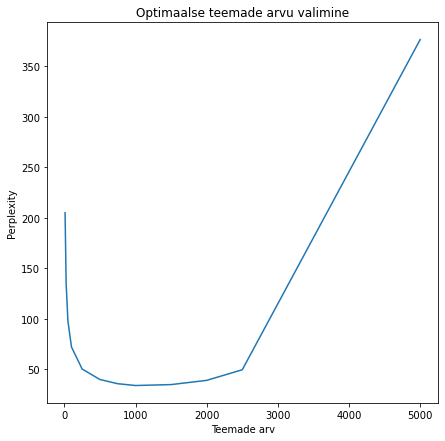

In [152]:
plt.figure(figsize=(7, 7))

plt.plot(n_components, perplexities)

plt.title("Optimaalse teemade arvu valimine")
plt.xlabel("Teemade arv")
plt.ylabel("Perplexity")
plt.savefig("optimal_model_perplexities_final.png")